## Near Miss -Sampling -  #700055807

In [2]:
#importing all modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_score,fbeta_score, accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

In [3]:
#importing white wine data set (UCI https://archive.ics.uci.edu/ml/datasets/wine+quality)

wine_df = pd.read_csv('data/winequality-white.csv', sep=';')

data = wine_df.copy()

In [4]:
#Creating the catigorical target, less than 8 as 0 and more than 8 as 1

data['type'] = np.where(data['quality'] < 8, 'bad', 'good')

In [5]:
# using the enconder to code 0,1 for bad and good respectvily 

le = LabelEncoder()
data['target'] = le.fit_transform(data['type'])

In [6]:
#using Near miss from imblearn

from imblearn.under_sampling import NearMiss

## Splitting and Resampling for train data only - Near Miss


In [6]:
# Separate input features and target
y = data.iloc[:,-1]
X = data.iloc[:,:-3]

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=27)

nm = NearMiss()
X_train, y_train = nm.fit_resample(X_train, y_train)

In [7]:
y_train[y_train == 1].shape
y_train[y_train == 0].shape

(130,)

In [8]:
log_NM = LogisticRegression(solver='liblinear')
log_NM.fit(X_train, y_train)
y_pred_log_NM = log_NM.predict(X_test)

In [9]:
accuracy_score(y_test, y_pred_log_NM)

0.4506122448979592

In [10]:
print(classification_report(y_test, y_pred_log_NM))

              precision    recall  f1-score   support

           0       0.96      0.45      0.61      1175
           1       0.04      0.54      0.07        50

    accuracy                           0.45      1225
   macro avg       0.50      0.49      0.34      1225
weighted avg       0.92      0.45      0.59      1225



No Skill: ROC AUC=0.500
Logistics Near Miss: ROC AUC=0.522


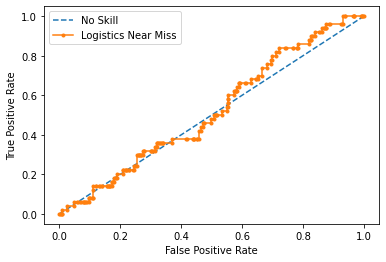

In [11]:
#AUC for Logistics


ns_probs = [0 for _ in range(len(y_test))]
y_pred_log_NM_proba = log_NM.predict_proba(X_test)
log_NM_probs = y_pred_log_NM_proba[:,1]
ns_auc = roc_auc_score(y_test, ns_probs)
log_NM_auc = roc_auc_score(y_test, log_NM_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistics Near Miss: ROC AUC=%.3f' % (log_NM_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
logNM_fpr, logNM_tpr, _ = roc_curve(y_test, log_NM_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(logNM_fpr, logNM_tpr, marker='.', label='Logistics Near Miss')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [13]:
# running the classifiers for the Near Miss sampling


model_scores = {}
model_roc_scores = {}
model_fbeta_score = {}
precision_scores = {}

DT_re_NM = DecisionTreeClassifier()
log_NM = LogisticRegression()
RF_NM = RandomForestClassifier()

for model in [DT_re_NM, log_NM, RF_NM]:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    model_scores[model] = score
    
    y_pred_proba = model.predict_proba(X_test)
    roc = roc_auc_score(y_test, y_pred_proba[:,1])
    model_roc_scores[model] = roc
    
    y_pred_proba = model.predict_proba(X_test)
    fb_score = fbeta_score(y_test, y_pred, beta=0.5)
    model_fbeta_score[model] = fb_score
    
    y_pred = model.predict(X_test)
    p_score = precision_score(y_test, y_pred)
    precision_scores[model] = p_score
    
    
model_scores
model_roc_scores
model_fbeta_score
precision_scores

roc_df = pd.DataFrame(list(model_roc_scores.items()),columns = ['Model','Roc Auc Score']) 
scores_df = pd.DataFrame(list(model_scores.items()),columns = ['Model1','Accuracy Score'])
precision_scores_df = pd.DataFrame(list(precision_scores.items()), columns=['Model3','Precision Score'])
fbeta_scores_df = pd.DataFrame(list(model_fbeta_score.items()), columns=['Model2','F_beta Score'])

total_scores_df = pd.concat([roc_df,scores_df ,precision_scores_df, fbeta_scores_df], axis=1)
total_scores_df.drop(['Model1', 'Model2', 'Model3'], axis=1, inplace=True)
total_scores_df.index.name = 'TOMEK Sampling'
total_scores_df = total_scores_df.round(2)
total_scores_df.index = ['DecisionTreeClassifier', 'LogisticRegression', 'RandomForestClassifier']
total_scores_df

/Users/mac/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Model,Roc Auc Score,Accuracy Score,Precision Score,F_beta Score
DecisionTreeClassifier,DecisionTreeClassifier(),0.51,0.32,0.04,0.05
LogisticRegression,LogisticRegression(),0.57,0.51,0.05,0.07
RandomForestClassifier,"(DecisionTreeClassifier(max_features='auto', r...",0.65,0.32,0.05,0.06


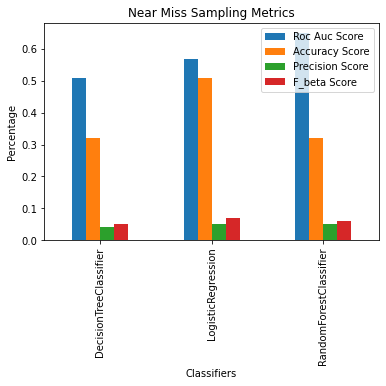

In [14]:
#plotting the comparison - Near Miss sampling

total_scores_df.plot(kind='bar')
plt.title('Near Miss Sampling Metrics')
plt.ylabel('Percentage')
plt.xlabel('Classifiers')
plt.show()

In [15]:
#final table for comparison

total_scores_df.drop('Model', axis=1)

,Roc Auc Score,Accuracy Score,Precision Score,F_beta Score
DecisionTreeClassifier,0.51,0.32,0.04,0.05
LogisticRegression,0.57,0.51,0.05,0.07
RandomForestClassifier,0.65,0.32,0.05,0.06


## Running classifiers for DT, RF, log in Near Miss

In [16]:
DT_re_NM = DecisionTreeClassifier()
DT_re_NM.fit(X_train, y_train)
y_pred_DT_NM = DT_re_NM.predict(X_test)

In [17]:
accuracy_score(y_test, y_pred_DT_NM)

0.34285714285714286

In [18]:
print(classification_report(y_test, y_pred_DT_NM))

              precision    recall  f1-score   support

           0       0.96      0.33      0.49      1175
           1       0.04      0.70      0.08        50

    accuracy                           0.34      1225
   macro avg       0.50      0.51      0.28      1225
weighted avg       0.92      0.34      0.47      1225



No Skill: ROC AUC=0.500
DT Near Miss: ROC AUC=0.514


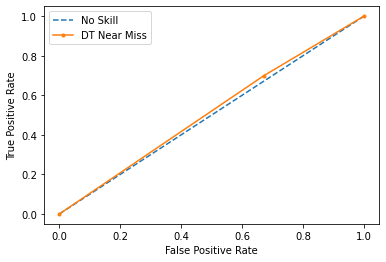

In [24]:
#AUC for DT

ns_probs = [0 for _ in range(len(y_test))]
y_pred_DT_re_NM_proba = DT_re_NM.predict_proba(X_test)
DT_NM_probs = y_pred_DT_re_NM_proba[:,1]
ns_auc = roc_auc_score(y_test, ns_probs)
DT_NM_auc = roc_auc_score(y_test, DT_NM_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('DT Near Miss: ROC AUC=%.3f' % (DT_NM_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
DTNM_fpr, DTNM_tpr, _ = roc_curve(y_test, DT_NM_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(DTNM_fpr, DTNM_tpr, marker='.', label='DT Near Miss')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [19]:
RF_NM = RandomForestClassifier()
RF_NM.fit(X_train, y_train)
y_pred_RF_NM = RF_NM.predict(X_test)
accuracy_score(y_test, y_pred_RF_NM)

0.34530612244897957

In [20]:
print(classification_report(y_test, y_pred_RF_NM))

              precision    recall  f1-score   support

           0       0.98      0.32      0.49      1175
           1       0.05      0.84      0.09        50

    accuracy                           0.35      1225
   macro avg       0.51      0.58      0.29      1225
weighted avg       0.94      0.35      0.47      1225



No Skill: ROC AUC=0.500
RF Near Miss: ROC AUC=0.679


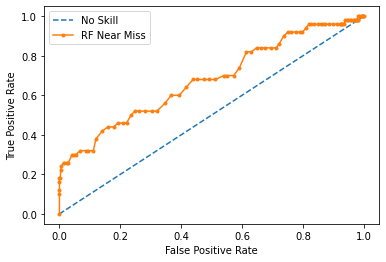

In [23]:
#AUC for RF

ns_probs = [0 for _ in range(len(y_test))]
y_pred_RF_NM_proba = RF_NM.predict_proba(X_test)
RF_NM_probs = y_pred_RF_NM_proba[:,1]
ns_auc = roc_auc_score(y_test, ns_probs)
RF_NM_auc = roc_auc_score(y_test, RF_NM_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('RF Near Miss: ROC AUC=%.3f' % (RF_NM_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
RFNM_fpr, RFNM_tpr, _ = roc_curve(y_test, RF_NM_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(RFNM_fpr, RFNM_tpr, marker='.', label='RF Near Miss')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

No Skill: ROC AUC=0.500
RF Near Miss: ROC AUC=0.679


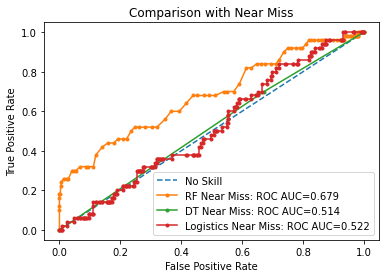

In [42]:
#AUC for ALL

ns_probs = [0 for _ in range(len(y_test))]
y_pred_RF_NM_proba = RF_NM.predict_proba(X_test)
RF_NM_probs = y_pred_RF_NM_proba[:,1]
ns_auc = roc_auc_score(y_test, ns_probs)
RF_NM_auc = roc_auc_score(y_test, RF_NM_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('RF Near Miss: ROC AUC=%.3f' % (RF_NM_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
RFNM_fpr, RFNM_tpr, _ = roc_curve(y_test, RF_NM_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(RFNM_fpr, RFNM_tpr, marker='.', label='RF Near Miss: ROC AUC=%.3f' % (RF_NM_auc))
plt.plot(DTNM_fpr, DTNM_tpr, marker='.', label='DT Near Miss: ROC AUC=%.3f' % (DT_NM_auc))
plt.plot(logNM_fpr, logNM_tpr, marker='.', label='Logistics Near Miss: ROC AUC=%.3f' % (log_NM_auc))


# axis labels
plt.title('Comparison with Near Miss')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()